# mDPP

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig
import os

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv, MDPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.models.rl.reinforce.baselines import CriticBaseline, RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.models.rl.reinforce.critic import CriticNetwork

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## mDPP Environment

We declare the environment here. This will automatically download the data 

In [2]:

data_dir = "../../data/"
data_file = "mdpp/mdpp10_test_seed1234.npz" # remember to generate data first


# In the mDPP problem we train directly on the test data as we want to search for best config
# of chip placement
env = MDPPEnv(reward_type="minmax", max_decaps=20, data_dir=data_dir,
              train_file=data_file, val_file=data_file, test_file=data_file)

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


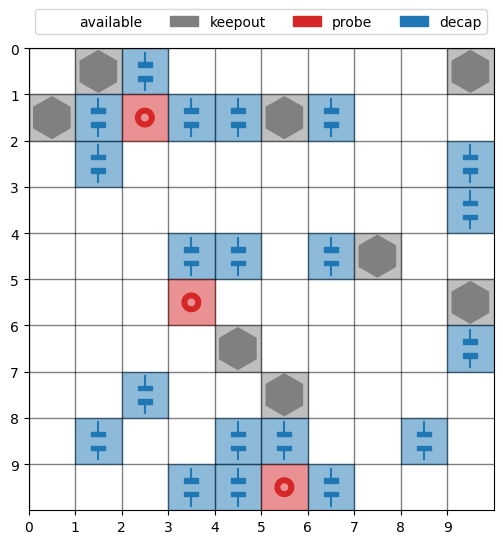

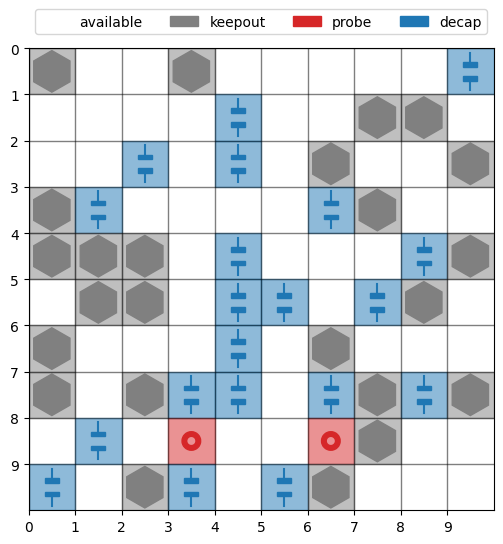

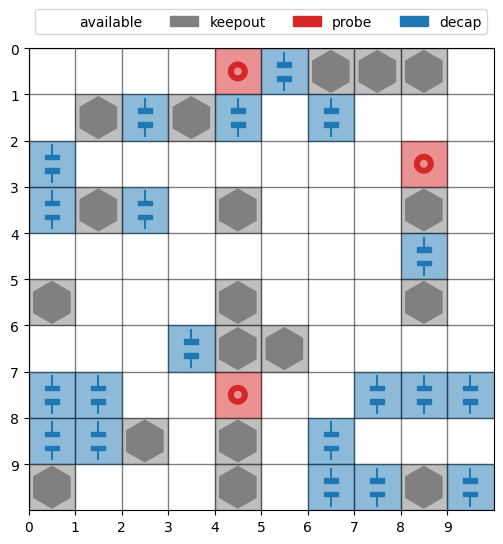

In [3]:
bs = 10


td = env.load_data(os.path.join(data_dir, data_file))
td = env.reset(td)

td_init = td.clone()

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

for i in range(20):
    # pick random action from action_mask
    td = random_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions_ = torch.stack(actions, dim=1)

# env.render(td[0], actions_[0])

for i in range(3):
    env.render(td[i], actions_[i])

## Attention Model

In [4]:
td = env.generate_data([100])
td


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([100, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)

In [5]:
td = env.load_data(os.path.join(data_dir, data_file))
td

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([100, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)

In [6]:
# Load environment with test data

dataset = env.dataset(phase="test")

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=tensordict_collate_fn,
)

policy = AttentionModelPolicy(
    env,
)

# model = torch.compile(model)

td = next(iter(dataloader))
td = env.reset(td)

out = policy(td, decode_type="greedy")

print(out)

{'reward': tensor([ 8.2276,  8.8068,  8.2019,  7.8464,  7.7983,  7.9740,  7.8036,  8.0087,
         7.8421,  6.9702,  7.4155,  8.3817,  8.3757,  7.7199,  7.8345, 10.1074,
         8.9447,  3.3629, 10.1546,  9.2121,  7.8317, 10.9688,  9.1299,  7.6811,
        10.3583,  8.7270,  8.8849,  7.9608,  7.8556,  9.1377,  9.3842,  7.4656,
        10.9323,  4.9527,  8.3766,  7.3388,  7.0157,  7.7753,  7.4004,  8.5420,
         7.8605,  7.6564, 10.5858,  8.0603,  7.9522,  8.4345,  8.0811,  9.3604,
         7.6621,  8.4148,  7.6915,  7.7316,  7.6101,  8.6446,  7.9415,  9.0573,
         8.6500,  9.5313,  7.0120,  8.6916,  7.5648,  8.8000,  7.3792,  7.4357]), 'log_likelihood': tensor([-72.4907, -66.8095, -75.2204, -65.2010, -75.9992, -67.0450, -74.6745,
        -63.5050, -61.7494, -66.5115, -57.7646, -66.9608, -67.0422, -64.7466,
        -74.2846, -59.9226, -67.4818, -62.4277, -64.4697, -71.0036, -73.6986,
        -56.8342, -78.7604, -71.7358, -71.2205, -64.2242, -74.0038, -74.7290,
        -77.0387,

In [7]:
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(
    env,
    policy,
    baseline,
)


td = next(iter(dataloader))

td = env.reset(td)
init_td = td.clone()


# out = model(td, decode_type="sampling")

# print(out)

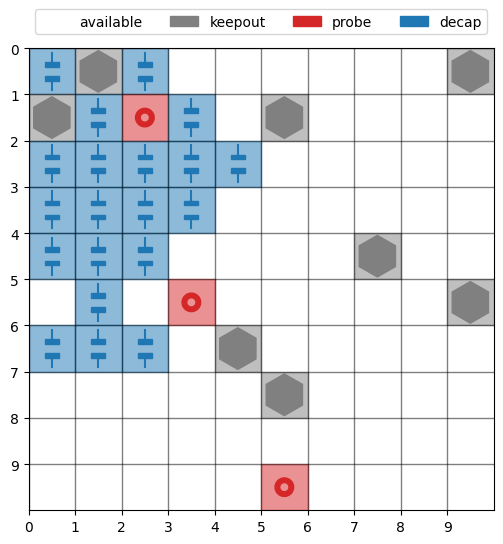

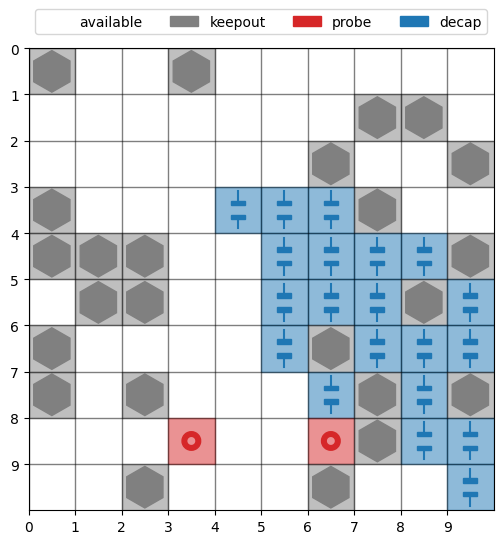

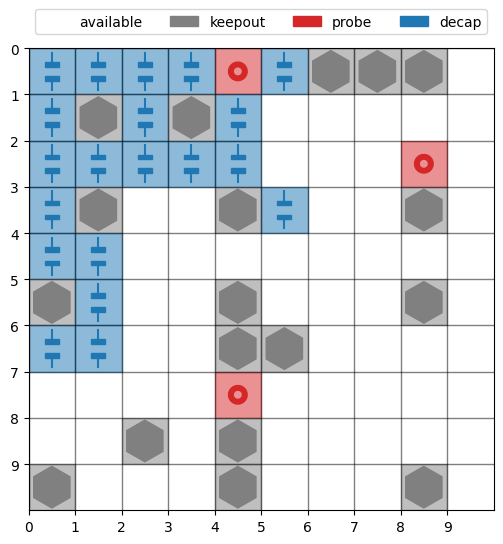

In [8]:
## Plot

probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(init_td[i], decaps[i])


# Main setup

In [16]:
config = DictConfig(
    {"data": {
            "train_size": 100, # with 1 epochs, this is 1k samples
            "val_size": 100,
            "batch_size": 16,
    },
    "optimizer": {
        "lr": 1e-4,
        "weight_decay": 0,
    },
    "num_epochs": 10,
    })

# Recreate model (so CUDA is initialized in the model)

# baseline = ExponentialBaseline()
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(env, baseline=baseline)

lit_module = RL4COLitModule(cfg=config, env=env, model=model)

In [17]:
# Trainer
trainer = L.Trainer(
    max_epochs=config.num_epochs, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    devices=[0], # GPU number, or multiple GPUs [0, 1, 2, ...]
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/lightning_logs
Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
No optimizer specified, using default

  | Name  | Type           | Params
-----------------------------------------
0 | env   | MDPPEnv        | 0     
1 | 

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging 

Training: 0it [00:00, ?it/s]

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())
/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states


Validation: 0it [00:00, ?it/s]

Loading training dataset from file. This may not be desired in RL since the dataset is fixed and the agent will not be able to explore new states
`Trainer.fit` stopped: `max_epochs=10` reached.


## Results

In [18]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")
batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(8.7762, device='cuda:0')

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


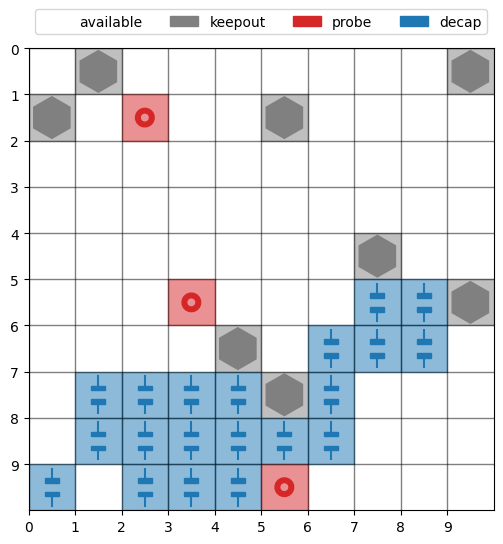

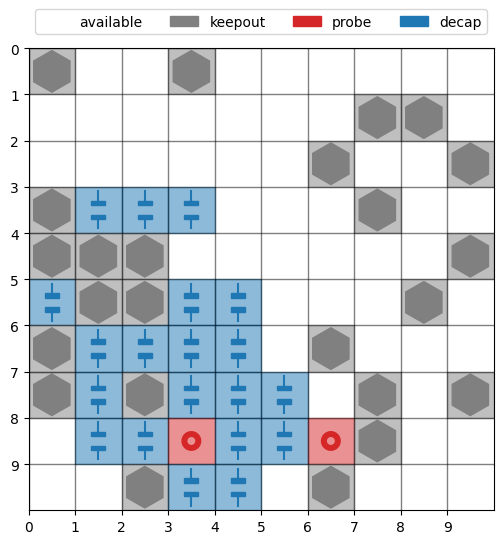

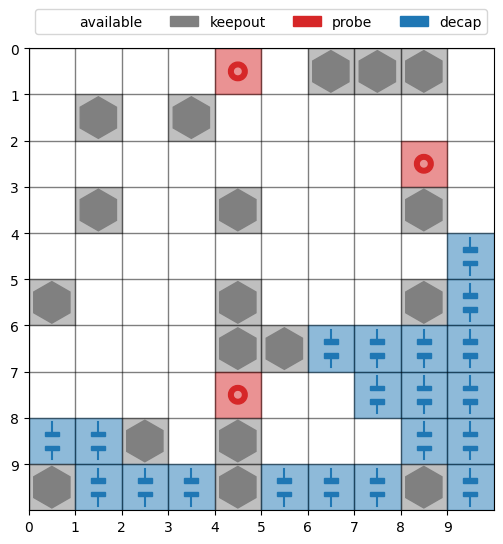

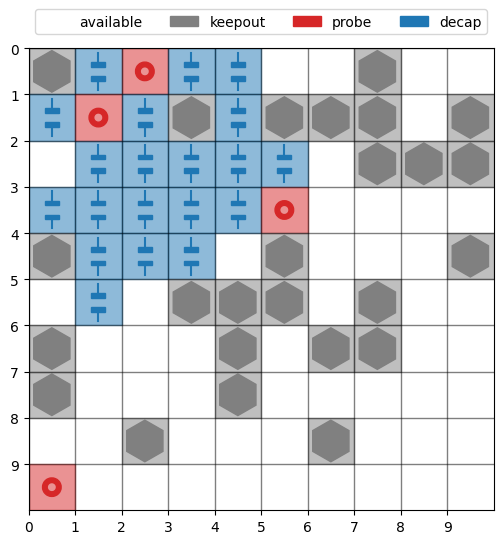

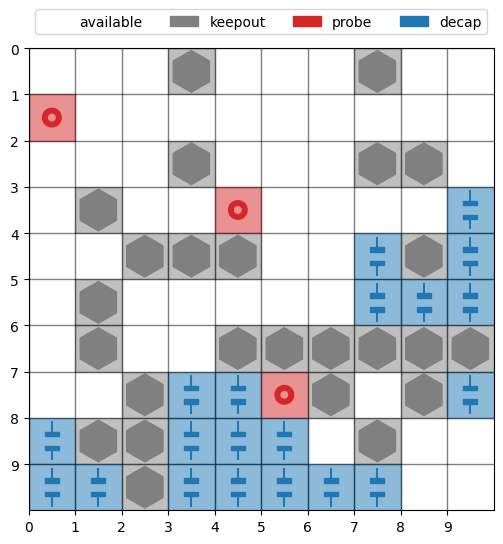

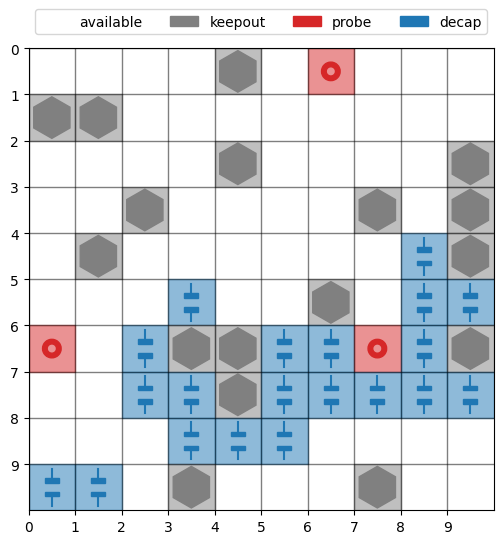

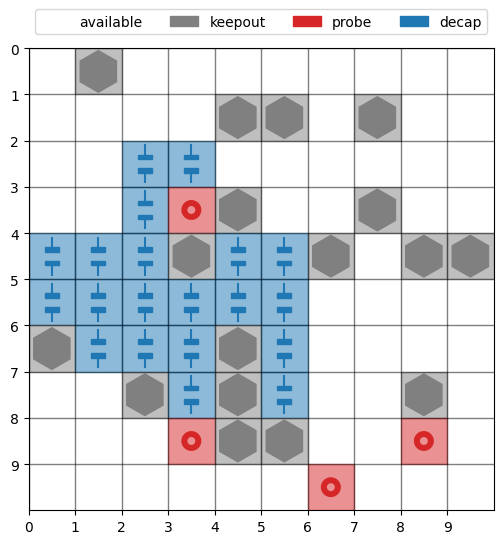

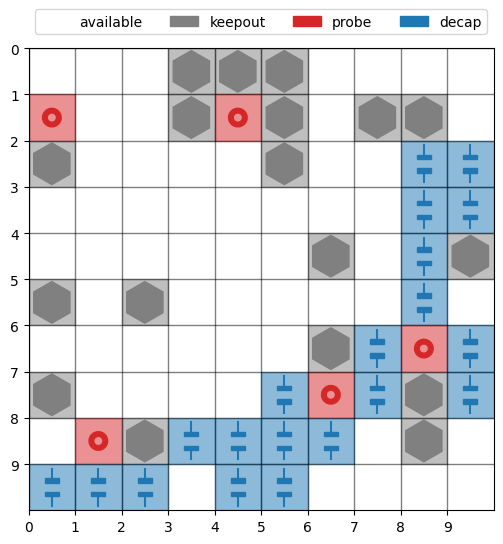

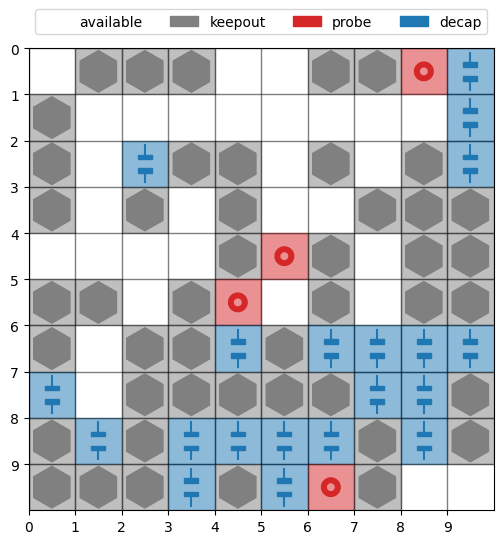

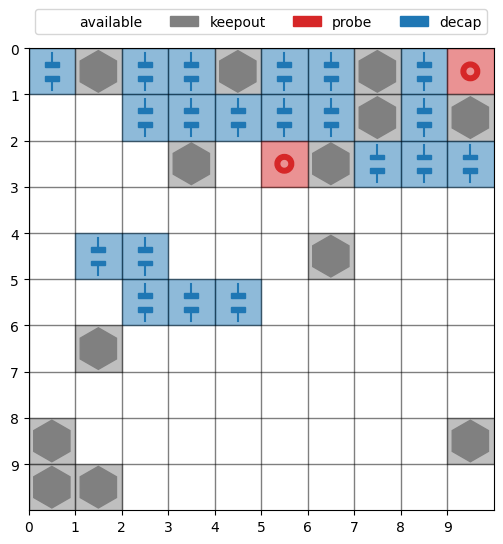

In [19]:
## Plot

init_td = env.reset(batch).to("cuda")
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(10):
    env.render(init_td[i], decaps[i])
